In [179]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

%matplotlib inline

In [180]:
N_PTS = 50

In [181]:
def tangle(points, weights=0.01, steps=1, normalize=True):
    for s in range(steps):
        diff = np.diff(points, axis=0)
        current_length = np.linalg.norm(diff, axis=-1)
        #target_length = np.mean(current_length) * 1.01
        #length_error = current_length - target_length
        curve = np.diff(diff, axis=0) * 0.1
        curve_right = curve - (np.sum(curve * diff[1:], axis=-1) / current_length[1:])[:, None] * diff[1:]
        curve_left = curve - (np.sum(curve * diff[:-1], axis=-1) / current_length[:-1])[:, None] * diff[:-1]
        sqr_dist = np.sum(diff * diff, axis=-1, keepdims=True)
        diff2 = points[2:] - points[:-2]
        sqr_dist2 = np.sum(diff2 * diff2, axis=-1, keepdims=True)
        if normalize:
            sqr_dist /= np.mean(sqr_dist)
            sqr_dist2 /= np.mean(sqr_dist2)
        diff2 /= sqr_dist2

        # Adjust length
        force = np.zeros_like(points)
        #length_force = length_error[:, None] * diff / current_length[:, None]
        force[:len(diff)] = diff #-length_force
        force[1:] -= diff #length_force

        # Repel from points 2 away
        # force[:len(diff2)] -= diff2
        # force[2:] += diff2

        # Straighten bends
        force[:len(curve)] -= curve_left
        force[2:] -= curve_right

        # force[:len(diff) - 1] -= diff1[1:]
        # force[2:] += diff1[:-1]

        # force *= 0.5
        
        points = points + weights * force
    return points

# def tangle_2(points, weights=0.0001, steps=1):
#     for s in range(steps):
#         sqr_distance_matrix = points @ points.T
#         mean_dist = np.mean(sqr_distance_matrix)
#         np.fill_diagonal(sqr_distance_matrix, np.inf)
#         pairwise_diff = (points[None] - points[:, None]) * 0.001

#         forces = -np.sum(pairwise_diff * mean_dist / sqr_distance_matrix[..., None], axis=1)

#         diff = np.diff(points, axis=0)
#         forces[:len(diff)] += diff
#         forces[1:] -= diff

#         points = points + weights * forces
#     return points

In [182]:
def generate():
    points = np.random.uniform(-1, 1, (N_PTS, 2))
    points = np.concatenate((np.linspace(-1, 1, N_PTS)[..., None], points), axis=-1)
    points[0] = np.array([-1, 0, 0])
    points[-1] = np.array([1, 0, 0])
    points[1] = np.array([-0.98, 0, 0])
    points[-2] = np.array([0.98, 0, 0])
    points[:, 2] *= 0.75
    points[:, 2] += 1
    
    weights = np.full((N_PTS, 1), 0.2)
    weights[0] = 0
    weights[-1] = 0
    tangled_pts = tangle(points, weights, steps=80)
    return tangled_pts

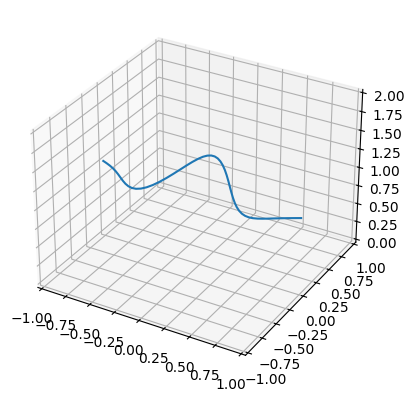

In [183]:
tangled_pts = generate()
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)

In [184]:
def skew(vecs):
    zeros = np.zeros(vecs.shape[:-1])
    arr = np.array([[        zeros, -vecs[..., 2],  vecs[..., 1]],
                    [ vecs[..., 2],         zeros, -vecs[..., 0]],
                    [-vecs[..., 1],  vecs[..., 0],         zeros]])
    # (3, 3, *batch)
    return np.moveaxis(arr, (0, 1), (-2, -1))

In [185]:
WIDTH = 640
HEIGHT = 480

import config
# CAMERA_POS = np.array([[0,   0,   0],
#                        [0.5, 0,   0],
#                        [0,   0.5, 0]])
# CAMERA_ROT = np.repeat(np.eye(3)[None], 3, 0)
# CAMERA_ROT[1] = np.array([[1, 0, 0],
#                           [0, 1 / np.sqrt(2), 1 / -np.sqrt(2)],
#                           [0, 1 / np.sqrt(2), 1 / np.sqrt(2)]])

# CAMERA_POS = config.G[..., :3, 3]
# CAMERA_ROT = config.G[..., :3, :3]

CAMERA_POS = np.random.uniform([-0.5, -0.5, -1], [0.5, 0.5, -0.5], size=(3, 3))
print(CAMERA_POS)
CAMERA_ROT = np.random.uniform([-12, -12, -12], [12, 12, 12], size=(3, 3))
CAMERA_ROT = Rotation.from_euler('xyz', CAMERA_ROT, degrees=True).as_matrix()
print(CAMERA_ROT.shape)
G = np.zeros((3, 4, 4))
G[:, :3, :3] = CAMERA_ROT
G[:, :3, 3] = CAMERA_POS
G[:, 3, 3] = 1

extrinsic = (np.linalg.inv(G[0]) @ G)[:, :3]
R = G[..., :3, :3]
T = G[..., :3, 3]
R = R.swapaxes(-1, -2) #extrinsic[..., :3]
T = (-R @ T[..., None])[..., 0]
# CAMERA_INT = np.array([[WIDTH,      0,  WIDTH / 2],
#                        [    0, HEIGHT, HEIGHT / 2],
#                        [    0,      0,          1]])
# ESSENTIALS = skew(-CAMERA_POS) @ CAMERA_ROT.swapaxes(-2, -1)
ESSENTIALS = R @ skew(T)
# PROJECTION = np.concatenate((CAMERA_ROT.swapaxes(-2, -1), -CAMERA_POS[..., None]), axis=-1)
PROJECTION = extrinsic
assert PROJECTION.shape == (3, 3, 4)

CAMERA_INT = np.eye(3)

def project(points, p_matrix):
    print(p_matrix.shape, points.shape)
    local_pts = p_matrix[:, None] @ points[..., None]
    return local_pts[..., 0] / local_pts[..., 2:, 0], local_pts[..., 2, 0]

# def draw(points):
#     canvas = np.ones((HEIGHT, WIDTH))
#     points = points.astype(int)
#     for i in range(len(points) - 1):
#         rr, cc = skimage.draw.line(points[i][1], points[i][0], points[i+1][1], points[i+1][0])
#         canvas[rr, cc] = 0
#     dist = sp.ndimage.distance_transform_edt(canvas)
#     grad_x = np.diff(dist, axis=1)
#     grad_y = np.diff(dist, axis=0)
#     return points, canvas, dist, grad_x, grad_y

# def optimize(points, grad_x, grad_y, weights=1, steps=100):
#     for s in range(steps):
#         force = np.zeros_like(points)

#         for c in range(3):
#             grads_x = sample_bilinear(grad_x[c], points)
#             grads_y = sample_bilinear(grad_y[c], points)
#             grads = np.stack((grads_x, grads_y), axis=-1)
#             force -= weights * grads

#             diff = np.diff(points, axis=0)
#             sqr_mag = np.sum(diff * diff, axis=-1, keepdims=True)
#             diff = diff / sqr_mag
            
#             force[:len(diff)] += diff
#             force[1:] -= diff

#         points = points + force

#         points += np.random.normal(0, 10 / (s + 1), points.shape)
#         points = np.clip(points, np.zeros(2), np.array((WIDTH, HEIGHT)))
#     return points

[[-0.43369369  0.29163676 -0.87248184]
 [ 0.1678631  -0.14307607 -0.69432441]
 [ 0.1567682   0.37144802 -0.66292814]]
(3, 3, 3)


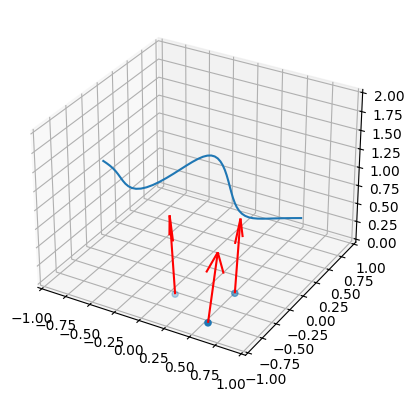

In [186]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 2)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)
ax.scatter(*CAMERA_POS.T)
ax.quiver(*CAMERA_POS.T, *CAMERA_ROT[..., 2].T, length=1, normalize=True, zorder=1, color='red')

In [187]:
def intersect_curves(epipolar_lines, points_h_2d):
    offsets = np.einsum('ijl,ikl->ijk', epipolar_lines, points_h_2d) #np.sum(epipolar_lines[:, :, None] * points_h_2d[:, None], axis=-1) # (c, n1, 1, 3) * (c, 1, n2, 3)
    sgn = np.sign(offsets)
    flip = sgn[..., 1:] - sgn[..., :-1]
    cc, n1, n2 = np.nonzero(flip)
    # Todo: handle multiple cameras (different number of intersects)
    diff = points_h_2d[cc, n2] - points_h_2d[cc, n2 + 1]
    rate = np.sum(epipolar_lines[cc, n1] * diff, axis=-1)
    factor = (-offsets[cc, n1, n2] / rate)[..., None]
    rate_normalized = rate / (np.linalg.norm(epipolar_lines[cc, n1], axis=-1) * np.linalg.norm(diff, axis=-1))
    return points_h_2d[cc, n2] + factor * diff, rate_normalized, cc, n1

# def pick_candidates(intersections):
    # pick candidates based on proximity and curvature to previous points

    # pass

(3, 3, 4) (50, 4)
[0.9013087  0.75856816 0.98868381] [1.29465171 1.28976824 1.42583897]


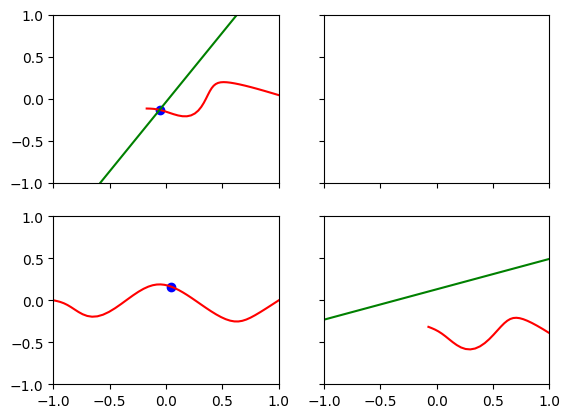

In [188]:
tangled_pts_h = np.concatenate((tangled_pts, np.ones((50, 1))), axis=-1)
points_2d_h, depth = project(tangled_pts_h, PROJECTION)
print(np.min(depth, axis=1), np.max(depth, axis=1))

last_depths = []
last_point = None
all_depths = []

e = ESSENTIALS[1:]
p = PROJECTION[1:]

epipolar_lines = (e[:, None] @ points_2d_h[0, ..., None])[..., 0]
assert epipolar_lines.shape == (2, N_PTS, 3)
intersections, rate_normalized, cc, n1 = intersect_curves(epipolar_lines, points_2d_h[1:])
assert intersections.shape == cc.shape + (3,)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].set_xlim((-1, 1))
axs[0, 0].set_ylim((-1, 1))

TEST_PT = 26

axs[1, 0].plot(*points_2d_h[0, ..., :2].T, color='red')
axs[1, 1].plot(*points_2d_h[1, ..., :2].T, color='red')
axs[0, 0].plot(*points_2d_h[2, ..., :2].T, color='red')
axs[1, 0].scatter(*points_2d_h[0, TEST_PT, :2], color='blue')
axs[1, 1].scatter(*intersections[np.logical_and(cc==0, n1==TEST_PT)][..., :2].T, color='blue')
axs[0, 0].scatter(*intersections[np.logical_and(cc==1, n1==TEST_PT)][..., :2].T, color='blue')

def points_on_epipolar(epipolar):
    a, b, c = epipolar
    p1 = np.array([a, b])
    p1 = -p1 * c / np.sum(p1 * p1)
    p2 = p1 + np.array([b, -a])
    return p1, p2

p1, p2 = points_on_epipolar(epipolar_lines[0, TEST_PT])
axs[1, 1].axline(p1, p2, color='green')

p1, p2 = points_on_epipolar(epipolar_lines[1, TEST_PT])
axs[0, 0].axline(p1, p2, color='green')
# fig = plt.figure() 

# marking the x-axis and y-axis 
# axis = plt.axes()
  
# initializing a line variable
# line, = axis.plot(*points_2d_h[1, ..., :2].T, color='red')
# scatter = axis.scatter(*intersections[cc==0][..., :2].T, color='blue') 

# def animate(i):
#     scatter.set_offsets(intersections[np.logical_and(cc==0, n1==int(i))][..., :2])
#     return [scatter]

# from matplotlib.animation import FuncAnimation
# anim = FuncAnimation(fig, animate,
#                      frames = N_PTS, interval = 200, blit = True) 
# anim.save('intersections.gif')

In [189]:
def get_depths(points1_matched, intersections, transformation):
    # get ray directions of matching points
    global_pts2 = (transformation[..., :3] @ intersections[..., None])[..., 0]
    # get other camera origin (same as ray origin of matching points)
    translation = transformation[None, ..., 3]
    # find perpendicular displacement from origin to each ray
    # by subtracting projection of translation onto ray
    projection = (np.sum(translation * global_pts2, axis=-1, keepdims=True)
                                   / np.sum(global_pts2 * global_pts2, axis=-1, keepdims=True)) * global_pts2
    perpendicular = translation - projection
    # find depths as length of perpendiculars divided by component of first camera rays on perpendiculars
    # basically, rays cast from camera 1 origin should reach the ray cast from camera 2
    return np.sum(perpendicular * perpendicular, axis=-1) / np.sum(points1_matched * perpendicular, axis=-1)

In [190]:
TRANSFORMATION = np.concatenate((CAMERA_ROT, CAMERA_POS[..., None]), axis=-1)
matches_1 = n1[cc==0]
depths_1 = get_depths(points_2d_h[0][matches_1], intersections[cc==0], TRANSFORMATION[1])
pos_1 = depths_1 > 0
split_idx_1 = np.unique(matches_1[pos_1], return_index=True)[1][1:]
corres_1 = np.split(depths_1[pos_1], split_idx_1)
assert all([all(c > 0) for c in corres_1])

matches_2 = n1[cc==1]
depths_2 = get_depths(points_2d_h[0][matches_2], intersections[cc==1], TRANSFORMATION[2])
pos_2 = depths_2 > 0
split_idx_2 = np.unique(matches_2[pos_2], return_index=True)[1][1:]
corres_2 = np.split(depths_2[pos_2], split_idx_2)
assert all([all(c > 0) for c in corres_2])

err = [c1[..., None] - c2[..., None, :] for c1, c2 in zip(corres_1, corres_2)]
assert len(err) == len(points_2d_h[0])
assert len(err) == N_PTS

AssertionError: 

In [ ]:
# TODO: pick multiple possible accepted depths and do beam search
# DEPTH_THRESHOLD = 0.02
# todo: use variable threshold based on rate
# accept = [er < DEPTH_THRESHOLD for er in err]
accept = [np.argmin(np.abs(er)) for er in err]
idx = np.array([np.unravel_index(acc, er.shape) for acc, er in zip(accept, err)])
depths = np.array([0.5 * (corres_1[i][idx[i, 0]] + corres_2[i][idx[i, 1]]) for i in range(N_PTS)])
points_3d = points_2d_h[0] * depths[..., None]

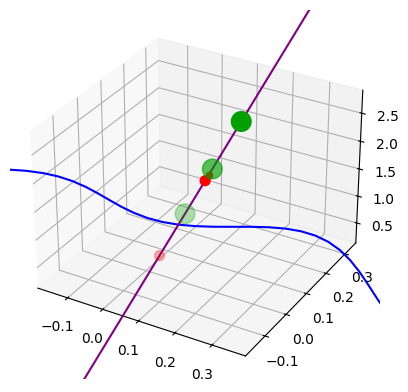

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
# ax.scatter(*tangled_pts.T)

candidates_3d_1 = points_2d_h[0, TEST_PT, :, None] * corres_1[TEST_PT][None]
candidates_3d_2 = points_2d_h[0, TEST_PT, :, None] * corres_2[TEST_PT][None]
ax.set_xlim3d(min(np.min(candidates_3d_1[0]), np.min(candidates_3d_2[0])) - 0.2, max(np.max(candidates_3d_1[0]), np.max(candidates_3d_2[0])) + 0.2)
ax.set_ylim3d(min(np.min(candidates_3d_1[1]), np.min(candidates_3d_2[1])) - 0.2, max(np.max(candidates_3d_1[1]), np.max(candidates_3d_2[1])) + 0.2)
ax.set_zlim3d(min(np.min(candidates_3d_1[2]), np.min(candidates_3d_2[2])) - 0.2, max(np.max(candidates_3d_1[2]), np.max(candidates_3d_2[2])) + 0.2)

ax.plot(*tangled_pts.T, color='blue')
ax.scatter(*points_3d[TEST_PT], color='red')
# plt.savefig('reconstruction.png')
ax.scatter(*candidates_3d_1, color='#ff0000', s=50)
ax.scatter(*candidates_3d_2, color='#00a000', s=200)
ax.plot(*np.stack((-10 * points_3d[TEST_PT], 10 * points_3d[TEST_PT]), axis=1), color='purple')

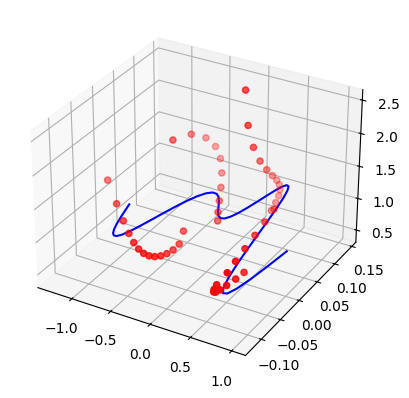

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*tangled_pts.T, color='blue')
ax.scatter(*points_3d.T, color='red')